# Import

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet 

In [33]:
def normalizar_data(df):
    df = df.select_dtypes(include="number")
    return (df - df.min()) / (df.max() - df.min())

In [34]:
def get_pol(x,p):
  ans=x
  for i in range(2,p+1):
    x_=np.power(x,i)
    ans=np.concatenate((ans,x_),axis=1)
  return ans

In [35]:
#df = pd.read_csv("/content/drive/MyDrive/forestfires.csv")
df = pd.read_csv("forestfires.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Split

In [36]:
df = df.select_dtypes(include="number")
train_, validate_, test_ = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.85*len(df))])

In [37]:
df_train=normalizar_data(train_)
df_validate=normalizar_data(validate_)
df_test=normalizar_data(test_)

## Polinomio de grado 2

In [38]:
df_train.insert(0, 'Bias', np.ones(df_train.shape[0]))
df_validate.insert(0, 'Bias', np.ones(df_validate.shape[0]))
df_test.insert(0, 'Bias', np.ones(df_test.shape[0]))

X_TRAIN=df_train[df_train.columns[:-1]].to_numpy()
X_TRAIN=get_pol(X_TRAIN,2)
Y_TRAIN=df_train[df_train.columns[-1]].to_numpy()
Y_TRAIN=Y_TRAIN.reshape(len(Y_TRAIN),1)

X_VALIDATE=df_validate[df_validate.columns[:-1]].to_numpy()
X_VALIDATE=get_pol(X_VALIDATE,2)
Y_VALIDATE=df_validate[df_validate.columns[-1]].to_numpy()
Y_VALIDATE=Y_VALIDATE.reshape(len(Y_VALIDATE),1)

X_TEST=df_test[df_test.columns[:-1]].to_numpy()
X_TEST=get_pol(X_TEST,2)
Y_TEST=df_test[df_test.columns[-1]].to_numpy()
Y_TEST=Y_TEST.reshape(len(Y_TEST),1)

# Model

In [39]:
def h(x, w):
    return np.dot(x,w)

In [40]:
def Error(x,w,y,lamda,typo):
  if typo=="MSE":
    return np.sum((y-h(x,w))**2)/(2.0*len(x)) + lamda*np.sum(w**2)
  if typo=="MAE":
    return np.sum(abs(y-h(x,w)))/(1.0*len(x)) + lamda * abs(np.sum(w))

In [41]:
def derivada(x,w,y,lamda,typo):
    n=len(x)
    if typo=="MSE":
      return (1/n)*(np.dot((y - h(x,w)).T,-1*x).T) + 2*lamda*w
    if typo=="MAE":
      return (1.0/(1.0*len(x)))*np.dot(((y-h(x,w))/abs(y-h(x,w))).T,-1*x).T + (lamda * w) / np.abs(w)

In [42]:
def update(w,  dw, alpha):
    w = w - alpha*dw 
    return w

In [43]:
def train1(x,y,alfa,lamda,epochs,typo):
    #print(X.shape)
    w = np.array([np.random.rand() for i in range(x.shape[1])])
    w= w.reshape(len(w),1)
    l = Error(x,w,y,lamda,typo)
    print(l)
    loss = []
    for i in range(epochs):
        dw = derivada(x, w, y,lamda,typo)
        w = update(w,dw,alfa)
        l = Error(x, w,y,lamda,typo)
        loss.append(l)
    return w, loss


def Plot_Loss(epochs,loss):
   plt.plot(epochs, loss)

In [44]:
def get_data(train, batch=4):
    indices = np.random.choice(train.shape[0], batch, replace=False)
    X_train = np.array(train.iloc[indices, :-1])
    y_train = np.array(train.iloc[indices, -1])
    return X_train, y_train

In [45]:
def train_complete(x, y, alfa, lamda, epochs, typo):
    w = np.array([np.random.rand() for i in range(x.shape[1])])
    w= w.reshape(len(w),1)
    loss_training = []
    loss_validation = []
    for i in range(epochs):
      dw=derivada(x,w,y,lamda,typo)
      w = update(w,dw,alfa)
      lt=Error(x,w,y,lamda,typo)
      lv=Error(X_VALIDATE,w,Y_VALIDATE,lamda,typo)
      loss_training.append(lt)
      loss_validation.append(lv)
    return w,loss_training,loss_validation

def Plot_Loss_both(epochs,loss_training,loss_validation):
    plt.plot(epochs, loss_validation)
    plt.plot(epochs, loss_training)
    plt.show()

13.299206754754856


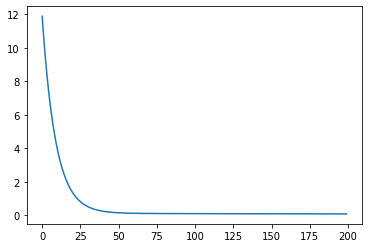

In [46]:
epochs=200
typo="MSE"
w,loss_trai=train1(X_TRAIN,Y_TRAIN,0.01,0,epochs,typo)
Plot_Loss([i for i in range(epochs)], loss_trai)

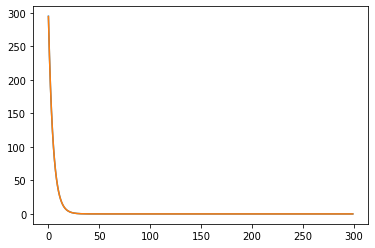

In [47]:
epochs=300
typo="MSE"
w,loss_training,loss_validation = train_complete(X_TRAIN, Y_TRAIN, 0.001,50,epochs,typo)
Plot_Loss_both([i for i in range(epochs)],loss_training,loss_validation)

In [48]:
def r_coef(w, X_TEST, Y_TEST):
   r2= 1 - np.sum((Y_TEST - np.dot(w.T,X_TEST.T))**2) / np.sum((Y_TEST - Y_TEST.mean())**2)
   return r2

In [49]:

learning_rate=[0.01,0.001, 0.0001, 0.00001]
epochs_array=[100, 200, 400, 800, 1500]
error_type=["MAE","MSE"]
dicc_ = {
    "MAE" : [],
    "MSE" : []
}

dicc = {
    0.01 : [],
    0.001 : [],
    0.0001 : [],
    0.00001 : []
}

dicc_loss = {
    0.01 : None,
    0.001 : None,
    0.0001 : None,
    0.00001 : None
}

dicc_validation = {
    0.01 : None,
    0.001 : None,
    0.0001 : None,
    0.00001 : None
}

typo = "MSE"

for i in learning_rate:
  for j in epochs_array:
    #for k in error_type:
      w, loss_training, loss_validation = train_complete(X_TRAIN, Y_TRAIN, i, 1,j,typo)
      dicc_loss[i] = loss_training
      dicc_validation[i] = loss_validation
      r2 = round(r_coef(w, X_TRAIN, Y_TRAIN), 3)
      dicc[i].append(r2)


$R^2$


In [50]:
pd.DataFrame(dicc, index = ["100", "200", "400", "800", "1500"])

,0.01000,0.00100,0.00010,0.00001
100,-597.212,-376473.513,-1038495.011,-2591760.591
200,-367.027,-103568.112,-1324787.815,-1946391.268
400,-361.103,-9505.074,-1510628.438,-2152411.178
800,-361.097,-1138.052,-727824.941,-2170245.273
1500,-361.097,-387.548,-283782.458,-1156145.910


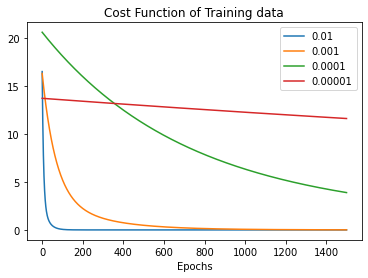

In [51]:
legends = ["0.01", "0.001", "0.0001", "0.00001"]
j = 0
for learning_rate, history in dicc_loss.items():
    plt.plot([i for i in range(len(history))], history, label = legends[j])
    j+=1
plt.title("Cost Function of Training data")
plt.xlabel("Epochs")
plt.legend()
plt.show()

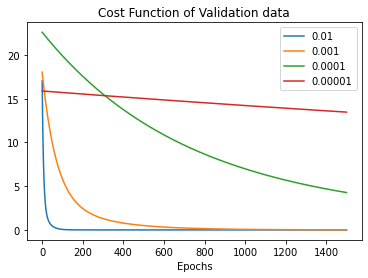

In [52]:
legends = ["0.01", "0.001", "0.0001", "0.00001"]
j = 0
for learning_rate, history in dicc_validation.items():
    plt.plot([i for i in range(len(history))], history, label = legends[j])
    j+=1
plt.title("Cost Function of Validation data")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Ridge

In [53]:
ridge_ = Ridge(alpha = 1.0)
ridge_.fit(X_TRAIN, Y_TRAIN)
print(f"Score: {ridge_.score(X_TEST, Y_TEST)}")

Score: -0.09311150841341154


# Lasso

In [54]:
lasso_model = Lasso(alpha = 1)
lasso_model.fit(X_TRAIN, Y_TRAIN)
print(f"Score: {lasso_model.score(X_TEST, Y_TEST)}") 

Score: -0.04223834553433781


# ElasticNet

In [55]:
regr = ElasticNet(random_state = 0, alpha = 1)
regr.fit(X_TRAIN, Y_TRAIN)
print(f"Score R^2: {regr.score(X_TEST, Y_TEST)}")

Score R^2: -0.04223834553433781
